# Document Form Filler
Fill out PDF document templates with computer or handwriting-style fonts.

**Works on:** Windows, Mac, Linux, Google Colab, Vertex AI Workbench

**Workflow:**
1. Convert your DOCX templates to PDF (one-time, on Windows: File → Save As → PDF)
2. Upload PDFs to the `documents/` folder
3. Use the coordinate picker to define field positions
4. Save field config to JSON
5. Fill document with values using computer or handwriting font

In [ ]:
# Setup - works on Windows, Mac, Linux, Colab, Vertex AI
import os
import sys
import json
import tempfile
import subprocess
import platform
from pathlib import Path
from IPython.display import display, Image as IPImage
import warnings
warnings.filterwarnings('ignore')

# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    os.system('pip install -q pymupdf pillow matplotlib')

# Install dependencies
try:
    import fitz  # PyMuPDF - handles PDF directly, no LibreOffice needed!
except ImportError:
    subprocess.check_call(['pip', 'install', 'pymupdf', '-q'])
    import fitz

try:
    from PIL import Image, ImageDraw, ImageFont
except ImportError:
    subprocess.check_call(['pip', 'install', 'Pillow', '-q'])
    from PIL import Image, ImageDraw, ImageFont

import matplotlib.pyplot as plt

print(f"Platform: {platform.system()}")
print(f"PyMuPDF version: {fitz.version}")
print("All dependencies loaded!")
print("\n** This notebook now supports PDF templates directly - no LibreOffice needed! **")

In [ ]:
# Configuration
DOCUMENTS_FOLDER = Path("documents")
FIELD_CONFIGS_FOLDER = Path("field_configs")
FONTS_FOLDER = Path("fonts")
OUTPUT_FOLDER = Path("filled_documents")

# Create folders if they don't exist
for folder in [DOCUMENTS_FOLDER, FIELD_CONFIGS_FOLDER, FONTS_FOLDER, OUTPUT_FOLDER]:
    folder.mkdir(parents=True, exist_ok=True)

# Resolution multiplier for rendering (2 = 2x resolution)
RENDER_SCALE = 2

print("Folders created/verified:")
print(f"  Documents: {DOCUMENTS_FOLDER}/")
print(f"  Field configs: {FIELD_CONFIGS_FOLDER}/")
print(f"  Fonts: {FONTS_FOLDER}/")
print(f"  Output: {OUTPUT_FOLDER}/")
print(f"\n** Put your PDF templates in the '{DOCUMENTS_FOLDER}/' folder **")

In [ ]:
def pdf_to_image(pdf_path, page_num=0):
    """Convert a PDF page to a PIL Image using PyMuPDF."""
    pdf_doc = fitz.open(str(pdf_path))
    page = pdf_doc[page_num]
    mat = fitz.Matrix(RENDER_SCALE, RENDER_SCALE)
    pix = page.get_pixmap(matrix=mat)
    
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    pdf_doc.close()
    return img

def load_field_config(config_path):
    """Load field configuration from JSON file."""
    with open(config_path, 'r') as f:
        return json.load(f)

def save_field_config(config, config_path):
    """Save field configuration to JSON file."""
    with open(config_path, 'w') as f:
        json.dump(config, f, indent=2)
    print(f"Saved config to {config_path}")

print("Helper functions loaded!")

In [ ]:
# List available PDF documents
documents = sorted([f for f in DOCUMENTS_FOLDER.iterdir() if f.suffix.lower() == '.pdf'])

if not documents:
    print(f"No PDF files found in '{DOCUMENTS_FOLDER}' folder.")
    print("\nTo use this notebook:")
    print("1. Convert your DOCX files to PDF (File → Save As → PDF in Word)")
    print("2. Upload the PDF files to the 'documents' folder")
    print("3. Re-run this cell")
else:
    print("Available PDF templates:")
    for i, doc in enumerate(documents):
        print(f"  {i}: {doc.name}")

In [ ]:
# Select document to work with
SELECTED_DOC_INDEX = 0  # Change this to select a different document

if documents:
    selected_doc = documents[SELECTED_DOC_INDEX]
    print(f"Selected: {selected_doc.name}")
    
    # Convert PDF to image
    template_img = pdf_to_image(selected_doc)
    print(f"Image size: {template_img.size}")
else:
    print("No documents available - upload PDF files to the 'documents' folder first")

In [ ]:
# Interactive Coordinate Picker
# Click on the image to mark positions - red dots appear, then sync to Python

import base64
import io
import json
from IPython.display import display, HTML, clear_output, Javascript
import ipywidgets as widgets
from ipywidgets import register_comm_target

# Global list to store positions
field_positions = []

if 'template_img' in dir():
    # Get image dimensions
    img_width, img_height = template_img.size
    
    # Scale for display
    max_display_width = 800
    scale = min(1.0, max_display_width / img_width)
    display_width = int(img_width * scale)
    display_height = int(img_height * scale)
    
    # Convert image to base64
    img_buffer = io.BytesIO()
    template_img.resize((display_width, display_height)).save(img_buffer, format='PNG')
    img_base64 = base64.b64encode(img_buffer.getvalue()).decode()
    
    picker_id = f"picker_{abs(hash(str(template_img.size)))}"[:12]
    
    # Output widgets
    status_output = widgets.Output()
    picker_output = widgets.Output()
    json_input = widgets.Textarea(
        value='[]',
        placeholder='Positions JSON will appear here after clicking',
        description='JSON:',
        layout=widgets.Layout(width='100%', height='60px')
    )
    
    def sync_from_json(b=None):
        """Parse positions from the JSON textarea."""
        global field_positions
        try:
            field_positions = json.loads(json_input.value)
            with status_output:
                clear_output(wait=True)
                if field_positions:
                    print(f"✓ Synced {len(field_positions)} positions to Python:")
                    for i, pos in enumerate(field_positions):
                        print(f"  {i+1}: x={pos['x']}, y={pos['y']}")
                else:
                    print("No positions yet. Click on the image above.")
        except Exception as e:
            with status_output:
                clear_output(wait=True)
                print(f"Error parsing JSON: {e}")
    
    def on_clear(b):
        global field_positions
        field_positions = []
        json_input.value = '[]'
        display_picker()
        sync_from_json()
    
    # Watch for changes in the textarea
    json_input.observe(lambda change: sync_from_json(), names='value')
    
    # Buttons
    sync_btn = widgets.Button(description='↻ Sync to Python', button_style='primary')
    clear_btn = widgets.Button(description='Clear All', button_style='warning')
    sync_btn.on_click(sync_from_json)
    clear_btn.on_click(on_clear)
    
    def display_picker():
        positions_json = json.dumps(field_positions)
        
        # Build SVG overlay with existing dots
        dots_svg = ""
        for i, pos in enumerate(field_positions):
            dx = int(pos['x'] * scale)
            dy = int(pos['y'] * scale)
            dots_svg += f'''
                <circle cx="{dx}" cy="{dy}" r="8" fill="red" stroke="darkred" stroke-width="2"/>
                <text x="{dx}" y="{dy}" fill="white" font-size="10" font-weight="bold" text-anchor="middle" dominant-baseline="middle">{i+1}</text>
            '''
        
        html_code = f'''
        <style>
            #{picker_id}_container {{ position: relative; display: inline-block; border: 2px solid #333; cursor: crosshair; }}
            #{picker_id}_overlay {{ position: absolute; top: 0; left: 0; pointer-events: none; }}
        </style>
        <div id="{picker_id}_container">
            <img id="{picker_id}_img" src="data:image/png;base64,{img_base64}" style="display: block;"/>
            <svg id="{picker_id}_overlay" width="{display_width}" height="{display_height}">{dots_svg}</svg>
        </div>
        <div id="{picker_id}_coords" style="margin-top:5px; font-family:monospace; color:#666;">Hover to see coordinates, click to mark</div>
        <div id="{picker_id}_status" style="font-family:monospace; color:green; font-weight:bold;"></div>
        
        <script>
        (function() {{
            const container = document.getElementById('{picker_id}_container');
            const img = document.getElementById('{picker_id}_img');
            const overlay = document.getElementById('{picker_id}_overlay');
            const coordsDiv = document.getElementById('{picker_id}_coords');
            const statusDiv = document.getElementById('{picker_id}_status');
            const scale = {scale};
            let positions = {positions_json};
            
            // Find the Textarea widget and update it
            function updateTextarea() {{
                const jsonStr = JSON.stringify(positions);
                // Find all textareas and update the one with our JSON
                const textareas = document.querySelectorAll('textarea.widget-input');
                for (const ta of textareas) {{
                    if (ta.value === '[]' || ta.value.startsWith('[{{') || ta.value.startsWith('[{{"x"')) {{
                        ta.value = jsonStr;
                        ta.dispatchEvent(new Event('input', {{bubbles: true}}));
                        break;
                    }}
                }}
                statusDiv.textContent = '✓ ' + positions.length + ' position(s) marked - Click "Sync to Python" or run next cell';
            }}
            
            container.addEventListener('mousemove', function(e) {{
                const rect = img.getBoundingClientRect();
                const x = Math.round((e.clientX - rect.left) / scale);
                const y = Math.round((e.clientY - rect.top) / scale);
                coordsDiv.textContent = 'x=' + x + ', y=' + y + ' (click to mark)';
            }});
            
            container.addEventListener('click', function(e) {{
                const rect = img.getBoundingClientRect();
                const displayX = e.clientX - rect.left;
                const displayY = e.clientY - rect.top;
                const actualX = Math.round(displayX / scale);
                const actualY = Math.round(displayY / scale);
                
                positions.push({{x: actualX, y: actualY}});
                
                // Draw marker
                const ns = 'http://www.w3.org/2000/svg';
                const g = document.createElementNS(ns, 'g');
                
                const circle = document.createElementNS(ns, 'circle');
                circle.setAttribute('cx', displayX);
                circle.setAttribute('cy', displayY);
                circle.setAttribute('r', '8');
                circle.setAttribute('fill', 'red');
                circle.setAttribute('stroke', 'darkred');
                circle.setAttribute('stroke-width', '2');
                g.appendChild(circle);
                
                const text = document.createElementNS(ns, 'text');
                text.setAttribute('x', displayX);
                text.setAttribute('y', displayY);
                text.setAttribute('fill', 'white');
                text.setAttribute('font-size', '10');
                text.setAttribute('font-weight', 'bold');
                text.setAttribute('text-anchor', 'middle');
                text.setAttribute('dominant-baseline', 'middle');
                text.textContent = positions.length;
                g.appendChild(text);
                
                overlay.appendChild(g);
                updateTextarea();
            }});
        }})();
        </script>
        '''
        
        with picker_output:
            clear_output(wait=True)
            display(HTML(html_code))
    
    print("=" * 60)
    print("INTERACTIVE COORDINATE PICKER")
    print("=" * 60)
    print("1. Click on the image to mark field positions (red dots)")
    print("2. Positions appear in the JSON box below")
    print("3. Click 'Sync to Python' or just run the NEXT CELL")
    print(f"\nImage: {img_width}x{img_height} px (displayed at {scale:.0%})")
    print("")
    
    display(picker_output)
    display(widgets.HBox([sync_btn, clear_btn]))
    display(json_input)
    display(status_output)
    
    display_picker()
    sync_from_json()
    
else:
    print("Load a template first (run the cells above)")

In [ ]:
# Load positions and name your fields
# Positions are synced from the picker above

# Try to sync from textarea if available
if 'json_input' in dir() and json_input.value != '[]':
    try:
        field_positions = json.loads(json_input.value)
    except:
        pass

print(f"Captured {len(field_positions)} positions:")
for i, pos in enumerate(field_positions):
    print(f"  {i+1}: x={pos['x']}, y={pos['y']}")

if not field_positions:
    print("\nNo positions captured yet.")
    print("1. Run the coordinate picker cell above")
    print("2. Click on the image to mark positions") 
    print("3. Re-run THIS cell to load them")

# ============================================================
# NAME YOUR FIELDS (in same order as positions clicked)
# ============================================================
field_names = [
    "field_1",
    "field_2", 
    "field_3",
    "field_4",
    "field_5",
    "field_6",
    "field_7",
    "field_8",
    "field_9",
    "field_10",
    # Add more if needed
]

# ============================================================
# Y-OFFSET: Adjust if text appears too high or low
# ============================================================
Y_OFFSET = -8

# Create config
if field_positions:
    config = {
        "template": selected_doc.name,
        "render_scale": RENDER_SCALE,
        "fields": []
    }
    
    for i, pos in enumerate(field_positions):
        name = field_names[i] if i < len(field_names) else f"field_{i+1}"
        config["fields"].append({
            "name": name,
            "x": pos['x'],
            "y": pos['y'] + Y_OFFSET
        })
    
    print(f"\nField config created with {len(config['fields'])} fields")

In [39]:
# Save field config to JSON
if 'config' in dir() and config.get('fields'):
    config_filename = selected_doc.stem + "_fields.json"
    config_path = FIELD_CONFIGS_FOLDER / config_filename
    save_field_config(config, config_path)
else:
    print("No field config to save. Run the coordinate picker first.")

Saved config to field_configs\Demand Letter_fields.json


In [40]:
def get_font(font_style="computer", size=24):
    """Get a font for text rendering.
    
    font_style: 'computer' for standard font, 'handwriting' for handwriting style
    """
    if font_style == "handwriting":
        # Look for handwriting fonts in the fonts folder
        handwriting_fonts = list(FONTS_FOLDER.glob("*.ttf")) + list(FONTS_FOLDER.glob("*.otf"))
        if handwriting_fonts:
            return ImageFont.truetype(str(handwriting_fonts[0]), size)
        else:
            print(f"No handwriting fonts found in {FONTS_FOLDER}. Using default.")
            print("Download a handwriting font (e.g., Caveat from Google Fonts) and place the .ttf file in the fonts folder.")
    
    # Default to Arial or system font
    try:
        return ImageFont.truetype("arial.ttf", size)
    except:
        try:
            return ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", size)
        except:
            return ImageFont.load_default()

def fill_document(template_img, field_config, values, font_style="computer", font_size=24, font_color="black"):
    """Fill a document template with values.
    
    template_img: PIL Image of the template
    field_config: dict with 'fields' list containing name, x, y
    values: dict mapping field names to values
    font_style: 'computer' or 'handwriting'
    font_size: font size in pixels
    font_color: color for the text
    
    Returns: PIL Image with text overlaid
    """
    # Make a copy of the template
    filled_img = template_img.copy()
    draw = ImageDraw.Draw(filled_img)
    font = get_font(font_style, font_size)
    
    for field in field_config.get('fields', []):
        field_name = field['name']
        if field_name in values:
            x, y = field['x'], field['y']
            text = str(values[field_name])
            draw.text((x, y), text, font=font, fill=font_color)
    
    return filled_img

In [ ]:
# ============================================================
# SELECT CONFIG FILE AND EDIT VALUES
# ============================================================

# Load saved config (or use the one in memory)
config_files = list(FIELD_CONFIGS_FOLDER.glob("*.json"))
if config_files:
    print("Available configs:")
    for i, cf in enumerate(config_files):
        print(f"  {i}: {cf.name}")

# SELECT WHICH CONFIG TO USE (change this number)
SELECTED_CONFIG_INDEX = 0

if config_files:
    config_path = config_files[SELECTED_CONFIG_INDEX]
    config = load_field_config(config_path)
    print(f"\n✓ Loaded config: {config_path.name}")
    print(f"  Fields: {[f['name'] for f in config['fields']]}")

# ============================================================
# EDIT THESE VALUES: What text to put in each field
# Field names must match the config above!
# ============================================================
sample_values = {
    "date": "January 15",
    "year": "26",
    "defendant_name": "John Doe",
    "address": "123 Main St",
    "address2": "Dallas, TX",
    "phone1": "555",
    "phone2": "111-1111",
    "case_info": "Case #001",
    "officer_name": "Officer Smith",
    "field_10": "Additional info"
}

Saved to filled_documents\Demand Letter_filled_computer.png


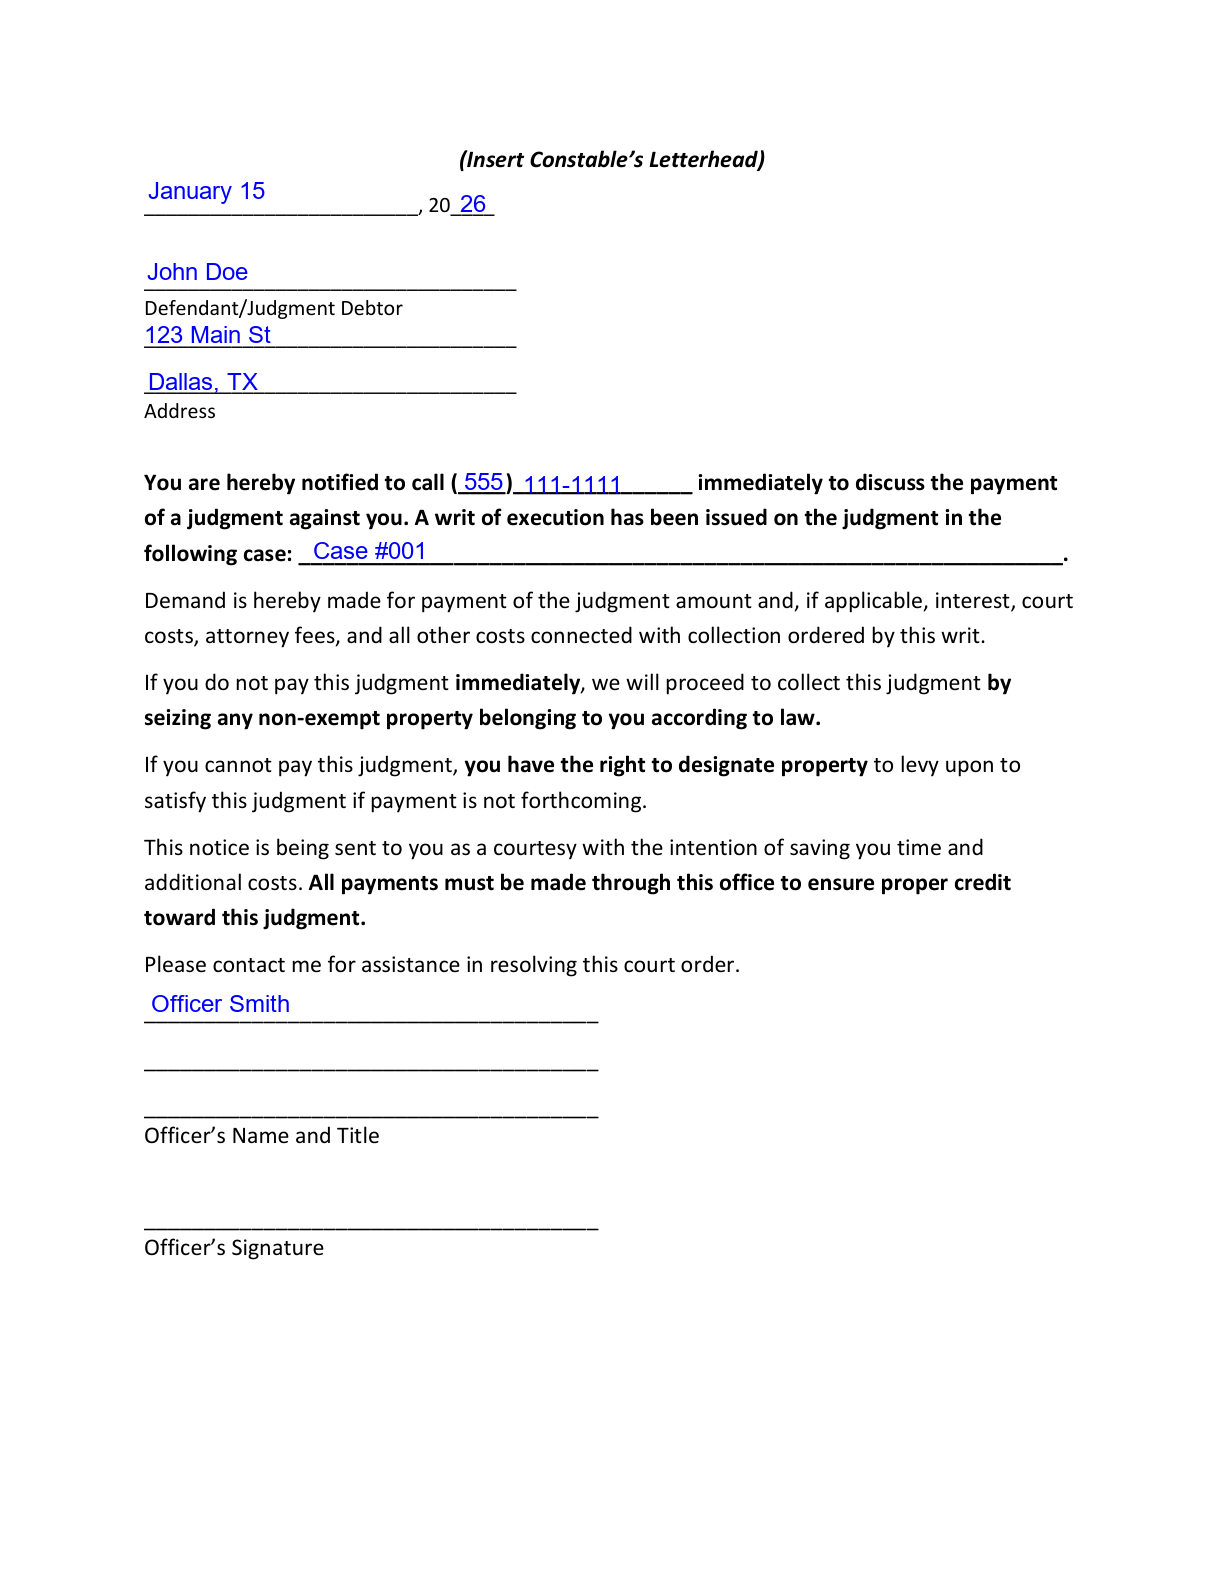

In [42]:
# Generate filled document with COMPUTER font

if 'template_img' in dir() and 'config' in dir():
    filled_computer = fill_document(
        template_img, 
        config, 
        sample_values, 
        font_style="computer",
        font_size=24,
        font_color="blue"
    )
    
    # Save
    output_path = OUTPUT_FOLDER / f"{selected_doc.stem}_filled_computer.png"
    filled_computer.save(output_path)
    print(f"Saved to {output_path}")
    
    # Display
    display(IPImage(filename=str(output_path), width=600))
else:
    print("Load a template and create field config first.")

No handwriting fonts found in fonts. Using default.
Download a handwriting font (e.g., Caveat from Google Fonts) and place the .ttf file in the fonts folder.
Saved to filled_documents\Demand Letter_filled_handwriting.png


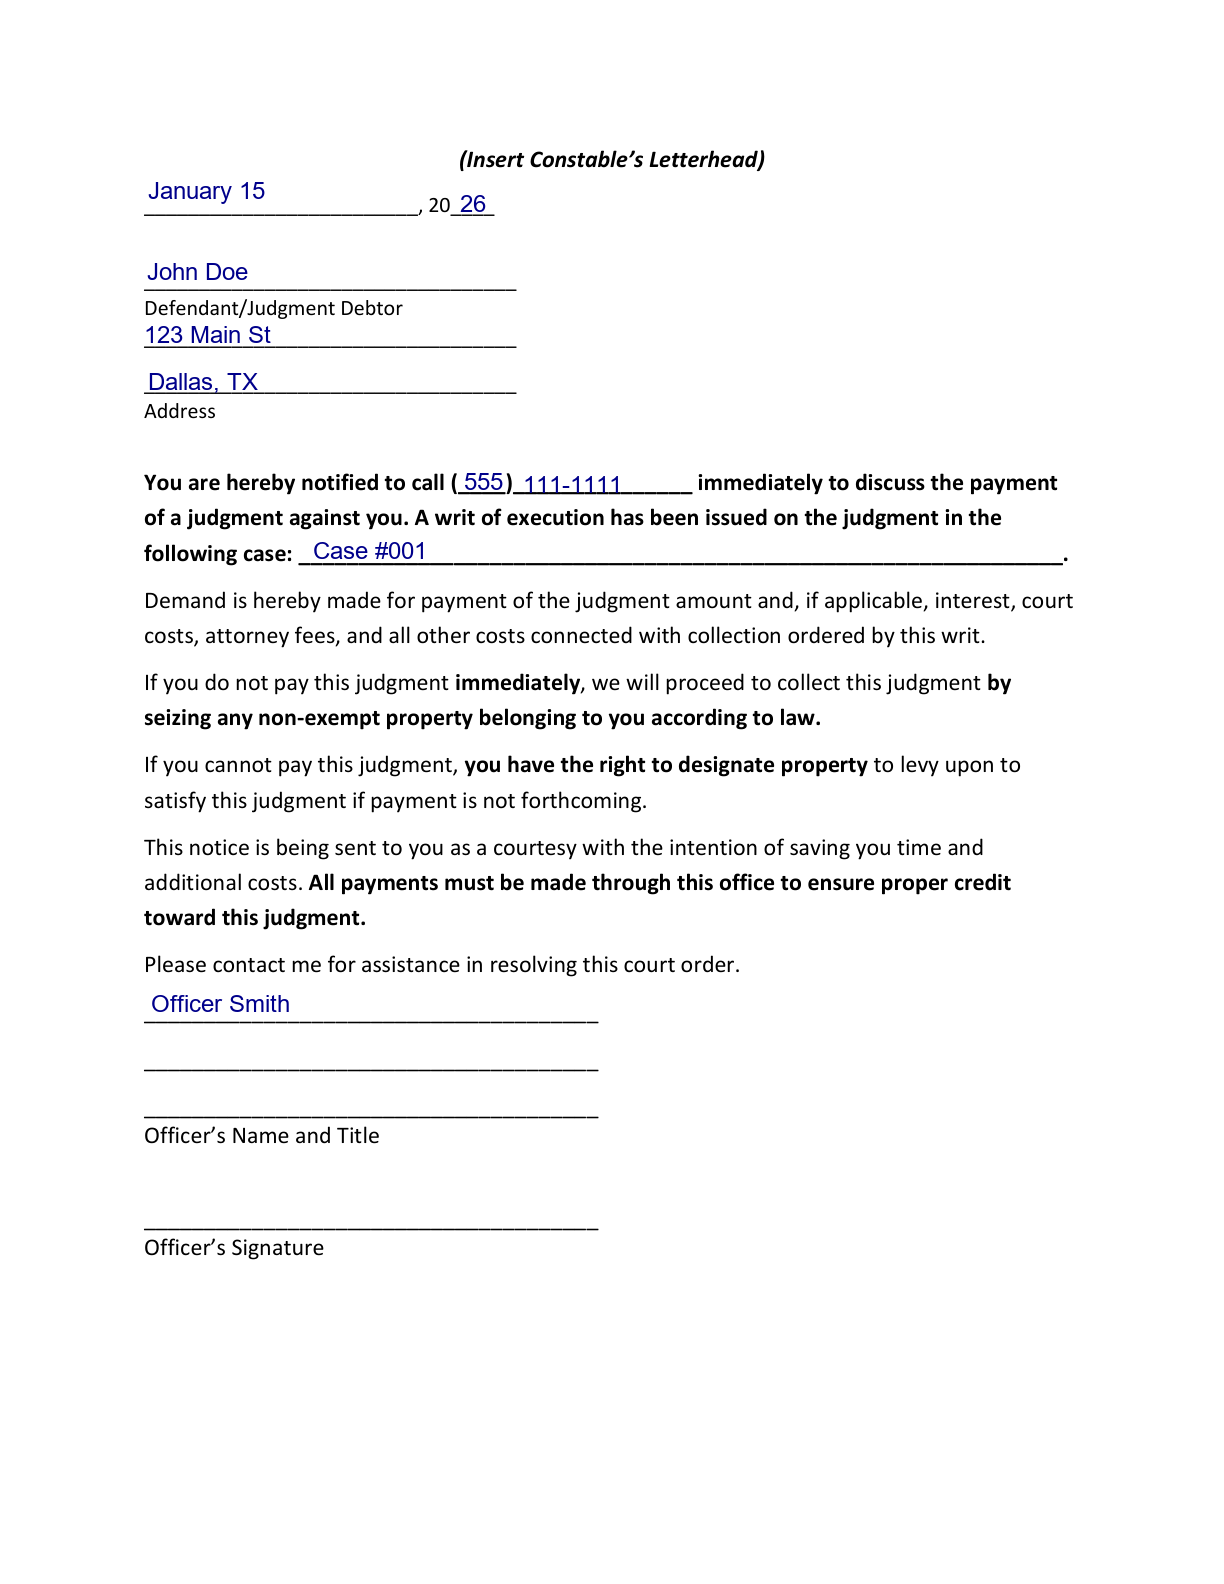

In [43]:
# Generate filled document with HANDWRITING font

if 'template_img' in dir() and 'config' in dir():
    filled_handwriting = fill_document(
        template_img, 
        config, 
        sample_values, 
        font_style="handwriting",
        font_size=24,
        font_color="darkblue"
    )
    
    # Save
    output_path = OUTPUT_FOLDER / f"{selected_doc.stem}_filled_handwriting.png"
    filled_handwriting.save(output_path)
    print(f"Saved to {output_path}")
    
    # Display
    display(IPImage(filename=str(output_path), width=600))
else:
    print("Load a template and create field config first.")

In [20]:
# Batch fill: Generate multiple versions with different values

batch_data = [
    {
        "date": "January 15",
        "year": "26",
        "defendant_name": "John Doe",
        "address": "123 Main St",
        "address2": "Dallas, TX",
        "phone1": "555",
        "phone2": "111-1111",
        "case_info": "Case #001",
        "officer_name": "Officer Smith"
    },
    {
        "date": "January 15",
        "year": "26",
        "defendant_name": "John Doe",
        "address": "123 Main St",
        "address2": "Dallas, TX",
        "phone1": "555",
        "phone2": "111-1111",
        "case_info": "Case #001",
        "officer_name": "Officer Smith"
    }
]

if 'template_img' in dir() and 'config' in dir():
    for i, values in enumerate(batch_data):
        filled = fill_document(template_img, config, values, font_style="computer", font_size=28)
        output_path = OUTPUT_FOLDER / f"{selected_doc.stem}_batch_{i+1}.png"
        filled.save(output_path)
        print(f"Saved: {output_path}")
else:
    print("Load a template and create field config first.")

Saved: filled_documents\Demand Letter_batch_1.png
Saved: filled_documents\Demand Letter_batch_2.png
